---
# Evaluate and plot the training results
---

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import BORDERS
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd 
from pyproj import Transformer
import scipy
import xarray as xr

In [3]:
# Pretty colours and plot layouting
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [4]:
# Set up a coordinate transformer for map plots
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

In [5]:
# Load the lookup table, containing coordinates and ISO codes
lookup_table = pd.read_csv("lookup_table.csv", index_col=0)

## 0. Load the FAO data and the samples

In [23]:
FAO_data = xr.open_dataarray(f"Datasets/Barley_pooled_0.99_2000-2022.nc")

def _get_iso3(country):
    if country not in lookup_table.index:
        return country
    _iso = lookup_table.loc[country, 'Alpha-3 code'] 
    return country if str(_iso) == 'nan' else _iso

# Convert the country names to an ISO3 code for easier labelling and selection
FAO_data = FAO_data.assign_coords({
    "Source": [_get_iso3(c) for c in FAO_data.coords["Source"].data],
    "Destination": [_get_iso3(c) for c in FAO_data.coords["Destination"].data]})

# Load the samples
samples = xr.open_dataset(f"Samples/Barley_pooled_0.99_2000-2022_samples_stats.nc")

## 1. Map plot

In [90]:
def _get_from_iso3(country, item):
    x = lookup_table[lookup_table['Alpha-3 code'] == country][item].values
    return x[0] if len(x) > 0 else np.nan

def plot_map(data: xr.DataArray, *, special_countries: list = None, extent: list = None, 
             width_factor: float = 1.0, special_edge_width_factor: float = 5e-5, size_factor: float = 1.0, arrow_dict: dict = {}, 
             min_edge_weight: float = 0.0):
    
    """ Plots a world map"""
    
    # Create an empty nx.network
    nw = nx.DiGraph()
    
    special_countries = [] if special_countries is None else special_countries
    
    export_nodes = data.sum("Destination", skipna=True)
    for country in export_nodes.coords['Source'].data:
        if country == 'Other' or np.isnan(_get_from_iso3(country, 'Latitude')):
            print(f"Missing coordinates for country '{country}'")
            continue
        nw.add_node(country, 
                    pos=(_get_from_iso3(country, 'Latitude'), _get_from_iso3(country, 'Longitude')), 
                    type='Exporter', 
                    export_value=2e-3*export_nodes.sel({"Source": country}).data.item(), import_value=0)
    
    # Add the importers
    import_nodes = data.sum("Source", skipna=True)
    for country in import_nodes.coords['Destination'].data:
        if country == 'Other' or np.isnan(_get_from_iso3(country, 'Latitude')):
            continue
        if country in nw.nodes():
            export_value = nw.nodes[country]["export_value"]
        else:
            export_value = 0
        nw.add_node(country, 
                    pos=(_get_from_iso3(country, 'Latitude'), _get_from_iso3(country, 'Longitude')), 
                    type='Importer', 
                    import_value=2e-3*import_nodes.sel({"Destination": country}).data.item(), export_value = export_value)
    
    # Add edges
    for country_A in data.coords["Source"].data:
        if country_A == "Other":
            continue
        for country_B in data.coords["Destination"].data:
            if country_B == "Other":
                continue

            # Skip special edges
            skip = False
            for special_country_pair in special_countries:
                if country_A == special_country_pair[0] and country_B == special_country_pair[1]:
                    skip = True
                    break
            if skip:
                continue

            T = data.sel({"Source": country_A, "Destination": country_B})
            if T > 0:
                if np.isnan(_get_from_iso3(country_A, 'Latitude')) or np.isnan(_get_from_iso3(country_B, 'Latitude')):
                    print(f"Missing edge {country_A} -> {country_B}")
                    continue
                nw.add_edge(country_A, country_B, weight=5e-5*T.data.item())

    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
    sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
    ax.axis('off')
    ax.add_feature(land, zorder=-2)
    ax.add_feature(sea, zorder=-3)
    ax.add_feature(BORDERS, lw=0.2, zorder=-1)
    
    # Plot the exporters
    pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
    size = nx.get_node_attributes(nw, 'export_value')
    nx.draw_networkx_nodes(nw, pos, node_size=size_factor * np.array(list(size.values())), ax=ax, node_color=colors["c_darkblue"], alpha=0.5)
    
    # Plot the importers
    size = nx.get_node_attributes(nw, 'import_value')
    nx.draw_networkx_nodes(nw, pos, node_size=size_factor * np.array(list(size.values())), ax=ax, node_color=colors["c_red"], alpha=0.5)

    # Add edges for special countries
    arrow_kwargs = dict(alpha=0.7, connectionstyle='arc3, rad=0.2', arrowsize=10)
    arrow_kwargs.update(**arrow_dict)

    for special_country_pair in special_countries:
        country_1, country_2 = special_country_pair
        nx.draw_networkx_edges(nw, {country_1: pos[country_1], country_2: pos[country_2]}, [special_country_pair], connectionstyle='arc3, rad=0.2', arrowstyle='-',
                           width=special_edge_width_factor*data.sel({"Source": country_1, "Destination": country_2}).data.item(), alpha=0.5)
    edges = [edge for edge in nw.edges if edge not in special_countries]
    _ = nx.draw_networkx_edges(nw, pos, edges, ax=ax, width=np.maximum(min_edge_weight, width_factor * np.array(list(nx.get_edge_attributes(nw, 'weight').values()))), **arrow_kwargs)


    # World
    extent = [-180, 180, -70, 60] if extent is None else extent
    ax.set_extent(extent)
    
    return fig, ax

Missing coordinates for country 'Serbia and Montenegro'
Missing coordinates for country 'Other'


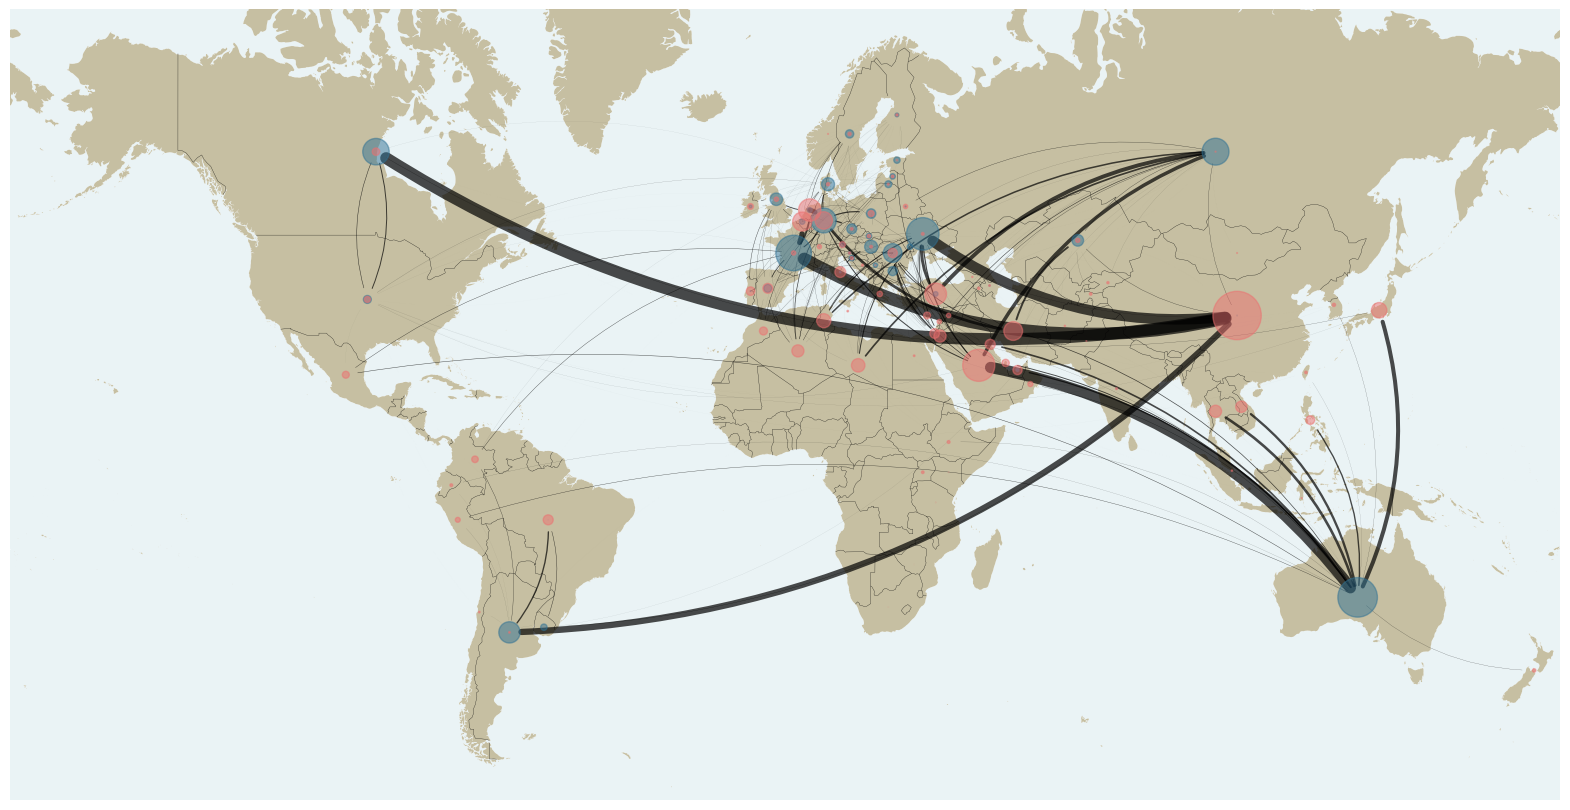

In [91]:
# Plot an example map: select the year and average over the Reporter
ds = FAO_data.sel({"Element": "Quantity, t", "Year": 2021}, drop=True).mean("Reporter", skipna=True)
fig, ax = plot_map(ds, arrow_dict=dict(arrowstyle='-'), extent=[-180, 180, -60, 73], size_factor=0.05, width_factor=5e-2)

## 2. Visualise predictions for country pairs

In [24]:
# Compare the prediction on an edge
def comparison_plot(exp, imp, *, figsize = (20, 5)):
    
    # Create a figure
    fig, axs = plt.subplots(ncols=4, figsize=figsize)
    fig.suptitle(f"{FAO_data.name} trade: {exp} to {imp}", fontsize=18, fontweight='bold')
    
    # Track the handles
    handles = dict((idx, []) for idx in range(len(axs)))
    
    for reporter in ['Exporter', 'Importer']:
        
        # True transport flow (quantity)
        _T = FAO_data.sel({"Reporter": reporter, "Element": "Quantity, t", "Source": exp, "Destination": imp}).dropna("Year")

        # True transport flow (value)
        _V = FAO_data.sel({"Reporter": reporter, "Element": "Value, 1000 USD", "Source": exp, "Destination": imp}).dropna("Year")
        
        # Interpolate the quantity and the value
        _x_t, _y_t = _T.coords["Year"], _T.data 
        _s_t = scipy.interpolate.PchipInterpolator(_x_t, _y_t, extrapolate=True)
        _x_v, _y_v = _V.coords["Year"], _V.data 
        _s_v = scipy.interpolate.PchipInterpolator(_x_v, _y_v, extrapolate=True)
        
        # Plot the true quantity flow
        _d = axs[0].scatter(_T.coords["Year"], _T, label=f"Reporter: {reporter}")
        axs[0].set_title(f"{_T.coords['Element'].data.item()}")
        handles[0].append(_d)
        
        # Plot the true value flow
        _d = axs[1].scatter(_V.coords["Year"], _V, label=f"Reporter: {reporter}")
        axs[1].set_title(f"{_V.coords['Element'].data.item()} (interpolated)")
        
        # Plot the interpolated value flow
        _x_v_interp = np.arange(_x_v.min(), _x_v.max()+1, 1)
        _l = axs[1].plot(_x_v_interp, _s_v(_x_v_interp))
        handles[1].append((_d, _l[0]))
        
        # Plot the value per unit
        _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
        _d = axs[2].scatter(_T.coords["Year"], _V / _T)
        axs[2].set_title("Unit cost (USD/kg)")
        handles[2].append((_d, _l[0]))
    
    # Plot the predicted transport flow
    _T_pred = samples.sel({"variable": "T_pred", "Source": exp, "Destination": imp})
    _fb = axs[0].fill_between(
        _T_pred.coords["Year"], 
        _T_pred["mean"] - _T_pred["std"], 
        _T_pred["mean"] + _T_pred["std"], 
        alpha=0.2, color=colors['c_darkblue']
    )
    _l = axs[0].plot(_T_pred.coords["Year"], _T_pred["mean"], 
                     color=colors['c_darkblue'], linestyle='dotted')
    handles[0].append((_fb, _l[0]))
    
    # Plot the predicted cost
    _C_pred = samples.sel({"variable": "C", "Source": exp, "Destination": imp})
    _fb = axs[3].fill_between(_C_pred.coords["Year"], 
                        _C_pred["mean"]-_C_pred["std"], 
                        _C_pred["mean"]+_C_pred["std"], alpha=0.2, color=colors['c_darkblue'])
    _l = axs[3].plot(_C_pred.coords["Year"], _C_pred["mean"], label="Predicted C", color=colors['c_darkblue'])
    axs[3].set_title("Predicted cost (unitless)")
    handles[3].append((_fb, _l[0]))
    
    # Add legends
    axs[0].legend(handles=handles[0], labels=['Exporter', 'Importer', 'Prediction'])
    axs[1].legend(handles=handles[1], labels=['Exporter', 'Importer'])
    axs[2].legend(handles=handles[2], labels=['Exporter', 'Importer'])
    axs[3].legend(handles=handles[3], labels=['Cost'])
    
    return fig, axs

/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_53468/30859960.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_53468/30859960.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))


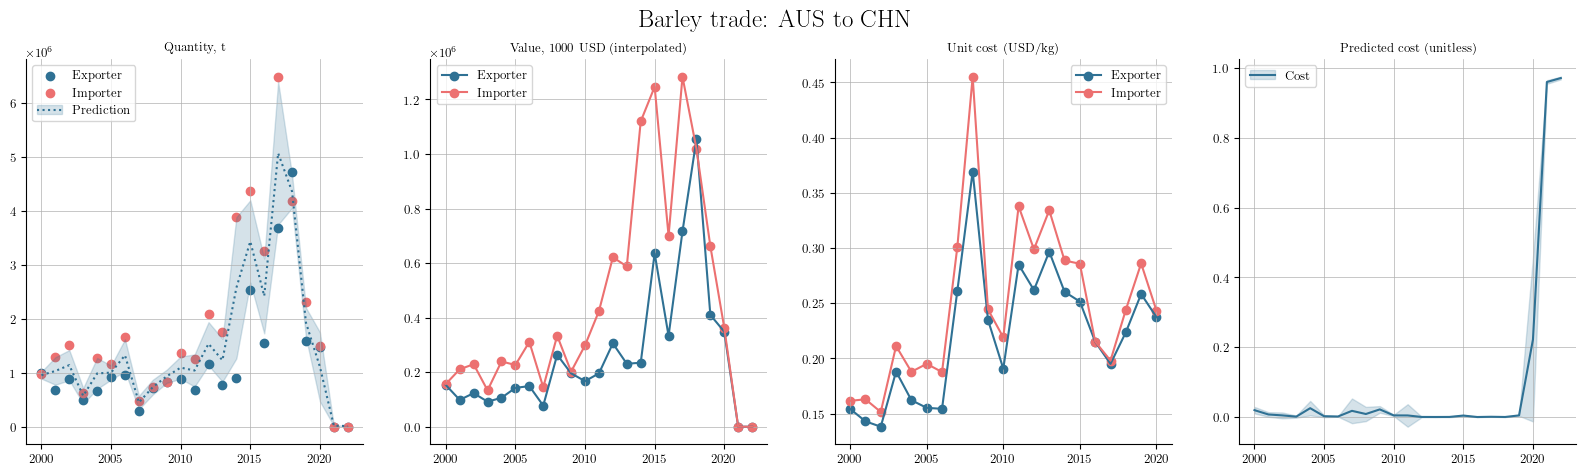

In [25]:
ex, im = "AUS", "CHN"
fig, axs = comparison_plot(ex, im)